<a href="https://colab.research.google.com/github/shizuo-kaji/TutorialTopologicalDataAnalysis/blob/master/TopologicalDataAnalysisWithPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tools for Topological Data Analysis
In this notebook, we will see
- What TDA offers for practitioners (Dimensiona reduction&Visualisation, Feature extraction)
- What types of input each method accepts (Point cloud, Image, Time series)
- How different tools can be used

In [0]:
## If you do not have the necessary libraries installed, run this cell (only for once)
## Be patient! It takes time.
# for standard libraries such as numpy, scipy, scikit-learn
# I recommend to use the package manager "conda". e.g.,  "conda install scikit-learn"
!pip install ripser umap-learn kmapper persim
!pip install git+https://github.com/shizuo-kaji/CubicalRipser_3dim


In [0]:
# load necessary libraries
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import glob,os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ripser import ripser
import persim


## Feature extraction from different data types

### Point cloud

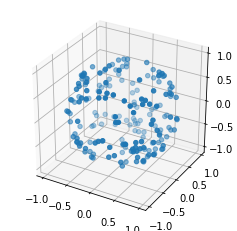

In [4]:
## random data on 2-sphere
X = np.random.rand(200,3)-0.5  # 200 random points in [-0.5,0.5]^3
X = X / np.sqrt(np.sum(X**2,axis=1,keepdims=True)) # normalize to have the unit length
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])

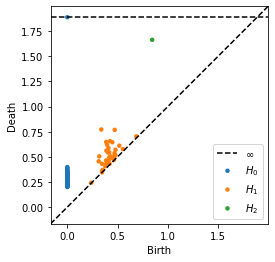

In [5]:
## compute persistent homology (PH) of the Vietoris-Rips (VR) complex and plot the persistence diagram (PD)
## VR-complex has a huge number of simplices. So the maximum number of points is in the order of 1000.
## You can compute an approximated PH by setting, e.g., "n_perm=100" (sub-sampling 100 points which are far apart).
diag = ripser(X,maxdim=2,n_perm=100)['dgms']
persim.plot_diagrams(diag)

     |████████████████████████████████| 4.7MB 6.9MB/s 
  Using cached https://files.pythonhosted.org/packages/89/e3/d576f6f02bc75bacbc3d42494e8f1d063c95617d86648dba243c2cb3963e/pybind11-2.5.0-py2.py3-none-any.whl
  ERROR: Failed building wheel for phat
  Running setup.py clean for phat
Failed to build phat
    Running setup.py install for phat ... done
Doing spatial.Delaunay triangulation...
Finished spatial.Delaunay triangulation (Elapsed Time 0.00803)
Building alpha filtration...
Finished building alpha filtration (Elapsed Time 0.58)
Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.0315)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.00406)


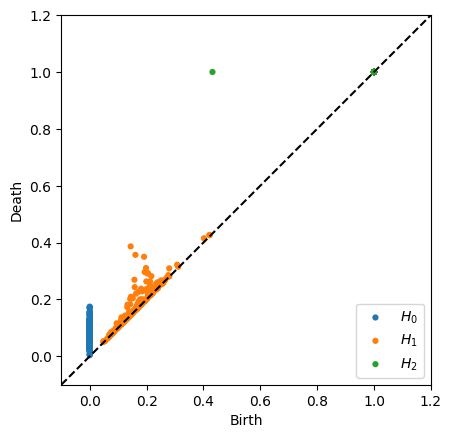

In [6]:
## from a point cloud, we can construct different complexes.
# The choice affects performance and the result, so we have to give a careful consideration
# Let's see an example of alpha complex.

##  we use "cechmate" package, but installation may fail on some machines
!pip install cechmate

import cechmate as cm
alpha = cm.Alpha()
filtration = alpha.build(X)
dgmsalpha = alpha.diagrams(filtration)
# We observe a notable difference in H_1 compared to the result of the VR complex above
persim.plot_diagrams(dgmsalpha)

### Distance between persistent diagrams
- classification/visualisation example

In [0]:
# sampling points from sphere and cube
def sample_sphere(n,radius=1):
    X = np.random.rand(n,3)-0.5
    X = X / np.sqrt(np.sum(X**2,axis=1,keepdims=True))
    X *= radius
    X += np.random.normal(scale=0.2,size=(len(X),3))
    X += np.random.uniform(-1,1,3)
    return(X)
def sample_cube(n,radius=1):
    X = 2*np.random.rand(n,3)-1
    X *= radius
    X += np.random.uniform(-1,1,3)
    return(X)
    

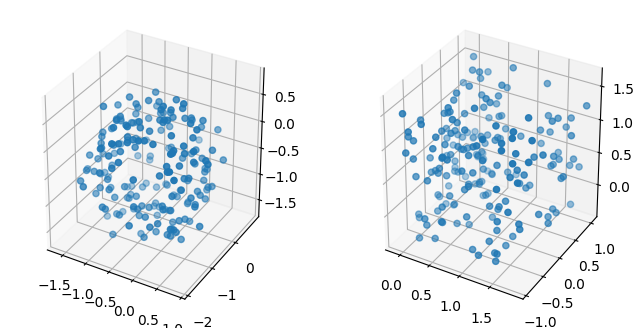

In [8]:
## create point clouds from sphere and cube and compute pairwise bottleneck distance of PH
n=5
X=[sample_sphere(200) for i in range(n)]
Y=[0]*n
X.extend([sample_cube(200) for i in range(n)])
Y.extend([1]*n)

## Plot the point clouds: for human eyes, it is not very easy to distinguish 3d point clouds
# sphere
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[0][:, 0], X[0][:, 1], X[0][:, 2])
# cube
ax = fig.add_subplot(122, projection='3d')
ax.scatter(X[n][:, 0], X[n][:, 1], X[n][:, 2])

# compute PH and distance
pd = []
for i in range(2*n):       
    pd.append(ripser(X[i],maxdim=2,n_perm=100)['dgms'][2])

D = np.zeros((2*n,2*n))
for i in range(2*n-1):
    for j in range(i+1,2*n):
        D[i,j]=persim.bottleneck(pd[i], pd[j])


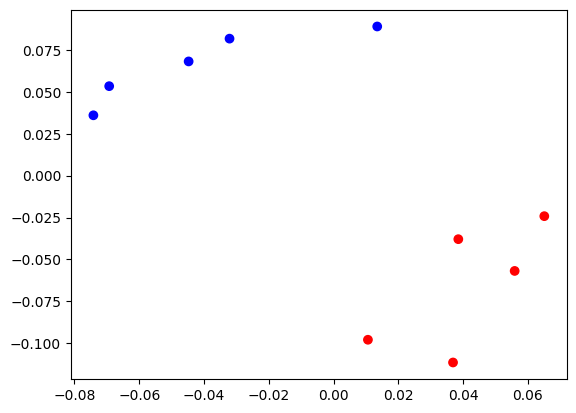

In [9]:
## Bottleneck distance discern spheres from cubes
# we use Multi-dimensional scaling, a method to embed finite metric spaces into a Euclidean space
# Blue dots represent cubes, red dots represent spheres
from sklearn.manifold import MDS
mds = MDS(n_components=2,dissimilarity='precomputed')
D = D+D.T
X_mds = mds.fit_transform(D)
col = ['r','b']
plt.scatter(X_mds[:,0],X_mds[:,1],c=[col[y] for y in Y])

### point cloud in an ambient metric space 

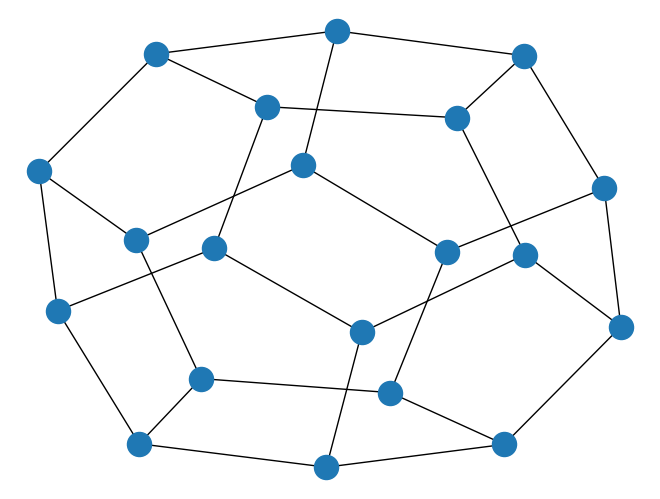

In [10]:
## VR complex can also be constructed from an abstract distance matrix.
# We see this through a graph distance example
import networkx as nx
G=nx.dodecahedral_graph()
nx.draw(G)
D=np.array(nx.floyd_warshall_numpy(G)) # distance matrix


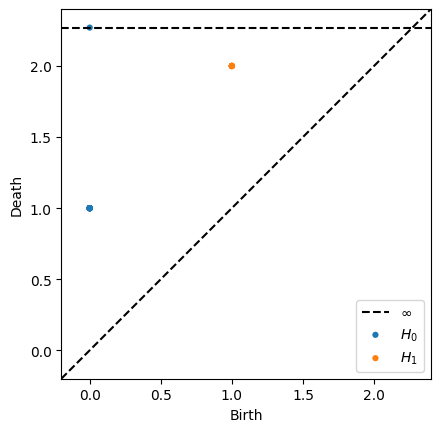

In [11]:
# compute persistence of a distance matrix
diag = ripser(D,distance_matrix=True)['dgms']
persim.plot_diagrams(diag)

# An interestin question is:
# for a set of point clouds, we can first compute PD for each point cloud and then compute the distance matrix of PDs.
# PH of the distance matrix defines a feature for "a set of point clouds".
# Do we have a practical application?

### Image and Volume

0 255 uint8


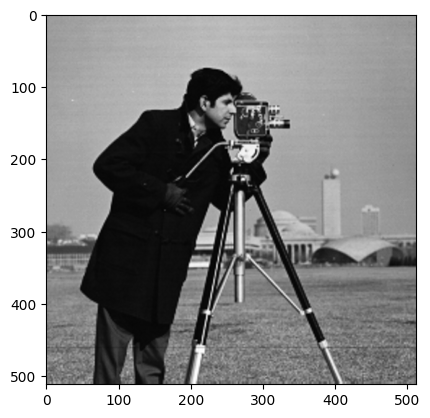

In [12]:
## greyscale photo
import skimage
from skimage import io
from PIL import Image
import cripser
# load a sample image
img = skimage.data.camera()
## if you want to upload your own image to Google Colab
#from google.colab import files
#img = skimage.color.rgb2gray(io.imread(list(files.upload().keys())[0]))

# plot
plt.imshow(img, cmap='gray')
print(np.min(img),np.max(img),img.dtype)

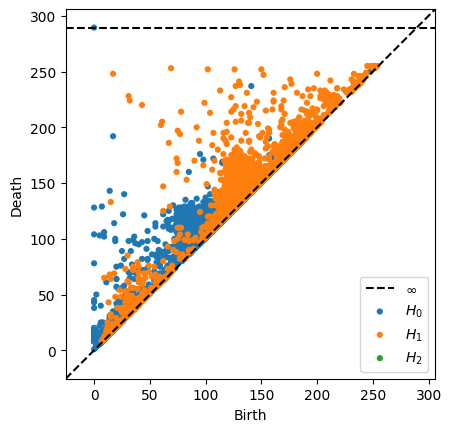

In [13]:
## compute persistence of the sublevel filtration
pd = cripser.computePH(img,maxdim=1,location="birth")
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

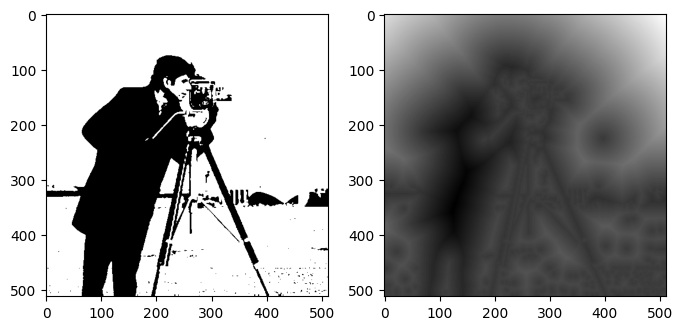

In [14]:
## For greyscale images, we have another notion of persistence than the sublevel filtration
# the following function makes the input image binary and apply distance transform
# the sublevel filtration is suitable when pixel values have significant meaning in your data (like the HU value in CT)
# while the distance transform is suitable when you are interested in the geometric structure of your data.
from scipy.ndimage.morphology import distance_transform_edt
from skimage.filters import threshold_otsu
bw_img = (img >= threshold_otsu(img))
dt_img = distance_transform_edt(bw_img)-distance_transform_edt(~bw_img)
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(bw_img,cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(dt_img, cmap='gray')

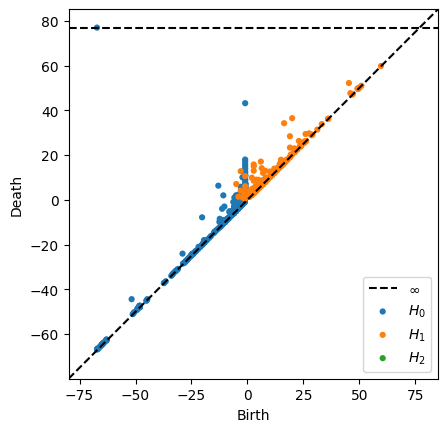

In [15]:
# compute persistence of the distance transform
pd = cripser.computePH(dt_img,maxdim=1,location="birth")
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

In [0]:
## compute the heatmap of cycles with specified birth-death properties
# the heatmap image reveals what kind of image features are captured by PH
def heat_map(img,pd,h=3,min_life = 10,max_life =255,min_birth = 0,max_birth = 255,dimension = 0,life_weighted=True):
  if len(img.shape)==2:
    mx,my=img.shape
    mz = 1
  else:
    mx,my,mz=img.shape

  selected_cycle = np.zeros((mx,my,mz))
  ppd = pd[pd[:,0] == dimension]
  ppd = ppd[min_life < ppd[:,2]-ppd[:,1]]
  ppd = ppd[ppd[:,2]-ppd[:,1] < max_life]
  ppd = ppd[min_birth < ppd[:,1]]
  ppd = ppd[ppd[:,1] < max_birth]
  w = 1
  for c in ppd:
      x,y,z=int(c[3]),int(c[4]),int(c[5])
      if life_weighted:
        w = c[2]-c[1]
      selected_cycle[max(0,x-h):min(mx,x+h),max(0,y-h):min(my,y+h),max(0,z-h):min(mz,z+h)] += w
#  print(np.min(selected_cycle),np.max(selected_cycle),np.sum(selected_cycle))
  return(np.squeeze(selected_cycle))

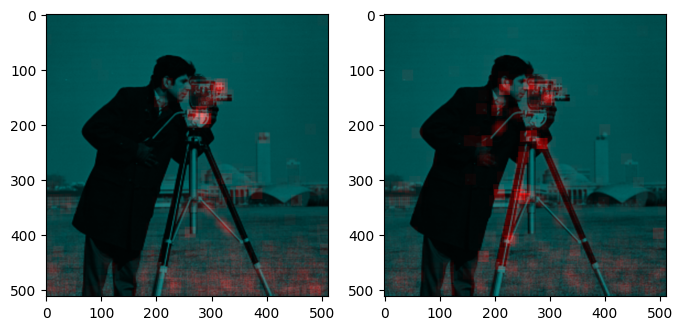

In [17]:
## Plot heatmap for H_0 and H_1
pd = cripser.computePH(img,maxdim=1,location="birth")
fig = plt.figure(figsize=(8, 4))
for i in range(2):
  heat=heat_map(img,pd,h=10,min_birth=10,dimension=i)
  heat = (heat/np.max(heat) * 255).astype(np.uint8)
  ax = fig.add_subplot(1,2,i+1)
  ax.imshow(np.dstack([heat,img//2,img//2]))


(512, 512, 8) 0.0 1.0


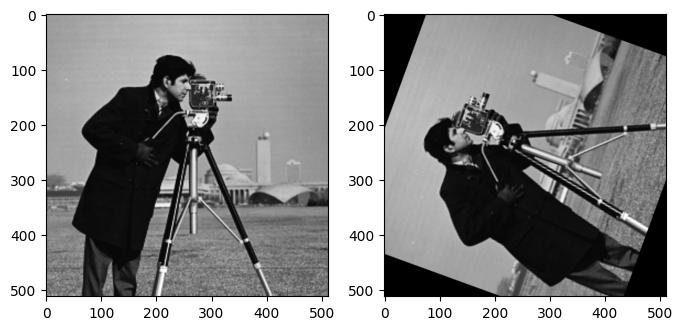

In [18]:
## 3D volume 
# create a dummy volume by stacking rotated greyscale images
from skimage.transform import rotate
vol = np.dstack([rotate(img, 10*i) for i in range(8)])

## load jpg files from disk and stack into a 3D array of type float64
#files = sorted([f for f in glob.glob("*.jpg")])
#vol = np.dstack([Image.open(f).convert('L') for f in files]).astype('f8')

#plot
print(vol.shape, np.min(vol),np.max(vol))
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.imshow(vol[:,:,0],cmap='gray')
ax = fig.add_subplot(122)
ax.imshow(vol[:,:,-1], cmap='gray')

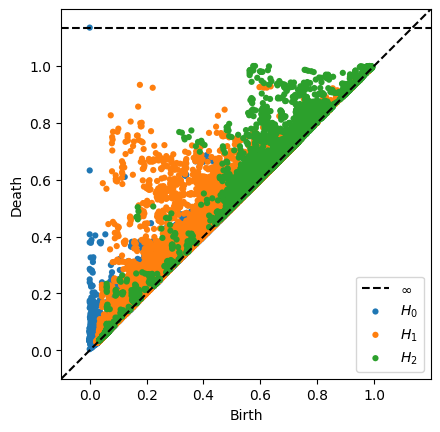

In [19]:
## compute persistence of the sublevel filtration
pd = cripser.computePH(vol,maxdim=2,location="birth")
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

### Time series

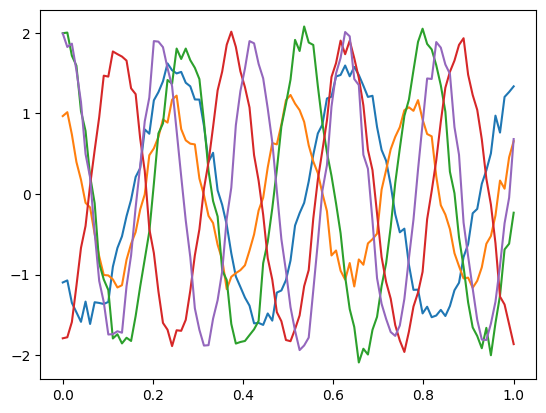

In [20]:
# synthetic example: regress the period of sine curve
n=200  # number of samples
t = np.linspace(0,1,100)
a=np.random.uniform(low=1,high=2,size=n)  # amplitude
b=np.random.uniform(low=1.5,high=7,size=n) # period
c=np.random.uniform(low=-np.pi,high=np.pi,size=n) # phase
# create different sine curves with noise
X = [a[i]*np.sin(2*np.pi*b[i]*t+c[i]) + np.random.normal(scale=0.1,size=len(t)) for i in range(n)]
for i in range(5):
    plt.plot(t,X[i])

In [0]:
## copied from persim package in order to fix a numpy incompatibility
## as of Jun 2020, the official persim (PersImage) is not compatible with Google Colab
from __future__ import division
from itertools import product
import collections

import numpy as np
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
import scipy.spatial as spatial
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin

__all__ = ["PersImage"]

class PersImage(TransformerMixin):
    """ Initialize a persistence image generator.

    Parameters
    -----------

    pixels : pair of ints like (int, int)
        Tuple representing number of pixels in return image along x and y axis.
    spread : float
        Standard deviation of gaussian kernel
    specs : dict
        Parameters for shape of image with respect to diagram domain. This is used if you would like images to have a particular range. Shaped like 
        ::
        
            {
                "maxBD": float,
                "minBD": float
            }

    kernel_type : string or ...
        TODO: Implement this feature.
        Determine which type of kernel used in the convolution, or pass in custom kernel. Currently only implements Gaussian.
    weighting_type : string or ...
        TODO: Implement this feature.
        Determine which type of weighting function used, or pass in custom weighting function.
        Currently only implements linear weighting.


    Usage
    ------


    """

    def __init__(
        self,
        pixels=(20, 20),
        spread=None,
        specs=None,
        kernel_type="gaussian",
        weighting_type="linear",
        verbose=True,
    ):

        self.specs = specs
        self.kernel_type = kernel_type
        self.weighting_type = weighting_type
        self.spread = spread
        self.nx, self.ny = pixels

        if verbose:
            print(
                'PersImage(pixels={}, spread={}, specs={}, kernel_type="{}", weighting_type="{}")'.format(
                    pixels, spread, specs, kernel_type, weighting_type
                )
            )

    def transform(self, diagrams):
        """ Convert diagram or list of diagrams to a persistence image.

        Parameters
        -----------

        diagrams : list of or singleton diagram, list of pairs. [(birth, death)]
            Persistence diagrams to be converted to persistence images. It is assumed they are in (birth, death) format. Can input a list of diagrams or a single diagram.

        """
        # if diagram is empty, return empty image
        if len(diagrams) == 0:
            return np.zeros((self.nx, self.ny))
        # if first entry of first entry is not iterable, then diagrams is singular and we need to make it a list of diagrams
        try:
            singular = not isinstance(diagrams[0][0], collections.Iterable)
        except IndexError:
            singular = False

        if singular:
            diagrams = [diagrams]

        dgs = [np.copy(diagram) for diagram in diagrams]
        landscapes = [PersImage.to_landscape(dg) for dg in dgs]

        if not self.specs:
            self.specs = {
                "maxBD": np.max([np.max(np.vstack((landscape, np.zeros((1, 2))))) 
                                 for landscape in landscapes] + [0]),
                "minBD": np.min([np.min(np.vstack((landscape, np.zeros((1, 2))))) 
                                 for landscape in landscapes] + [0]),
            }
        imgs = [self._transform(dgm) for dgm in landscapes]

        # Make sure we return one item.
        if singular:
            imgs = imgs[0]

        return imgs

    def _transform(self, landscape):
        # Define an NxN grid over our landscape
        maxBD = self.specs["maxBD"]
        minBD = min(self.specs["minBD"], 0)  # at least show 0, maybe lower

        # Same bins in x and y axis
        dx = maxBD / (self.ny)
        xs_lower = np.linspace(minBD, maxBD, self.nx)
        xs_upper = np.linspace(minBD, maxBD, self.nx) + dx

        ys_lower = np.linspace(0, maxBD, self.ny)
        ys_upper = np.linspace(0, maxBD, self.ny) + dx

        weighting = self.weighting(landscape)

        # Define zeros
        img = np.zeros((self.nx, self.ny))

        # Implement this as a `summed-area table` - it'll be way faster
        spread = self.spread if self.spread else dx
        for point in landscape:
            x_smooth = norm.cdf(xs_upper, point[0], spread) - norm.cdf(
                xs_lower, point[0], spread
            )
            y_smooth = norm.cdf(ys_upper, point[1], spread) - norm.cdf(
                ys_lower, point[1], spread
            )
            img += np.outer(x_smooth, y_smooth) * weighting(point)
        img = img.T[::-1]
        return img

    def weighting(self, landscape=None):
        """ Define a weighting function, 
                for stability results to hold, the function must be 0 at y=0.    
        """

        # TODO: Implement a logistic function
        # TODO: use self.weighting_type to choose function

        if landscape is not None:
            if len(landscape) > 0:
                maxy = np.max(landscape[:, 1])
            else: 
                maxy = 1

        def linear(interval):
            # linear function of y such that f(0) = 0 and f(max(y)) = 1
            d = interval[1]
            return (1 / maxy) * d if landscape is not None else d

        def pw_linear(interval):
            """ This is the function defined as w_b(t) in the original PI paper

                Take b to be maxy/self.ny to effectively zero out the bottom pixel row
            """

            t = interval[1]
            b = maxy / self.ny

            if t <= 0:
                return 0
            if 0 < t < b:
                return t / b
            if b <= t:
                return 1

        return linear

    def kernel(self, spread=1):
        """ This will return whatever kind of kernel we want to use.
            Must have signature (ndarray size NxM, ndarray size 1xM) -> ndarray size Nx1
        """
        # TODO: use self.kernel_type to choose function

        def gaussian(data, pixel):
            return mvn.pdf(data, mean=pixel, cov=spread)

        return gaussian

    @staticmethod
    def to_landscape(diagram):
        """ Convert a diagram to a landscape
            (b,d) -> (b, d-b)
        """
        diagram[:, 1] -= diagram[:, 0]

        return diagram

    def show(self, imgs, ax=None):
        """ Visualize the persistence image

        """

        ax = ax or plt.gca()

        if type(imgs) is not list:
            imgs = [imgs]

        for i, img in enumerate(imgs):
            ax.imshow(img, cmap=plt.get_cmap("plasma"))
            ax.axis("off")


PersImage(pixels=[10, 10], spread=1, specs=None, kernel_type="gaussian", weighting_type="linear")


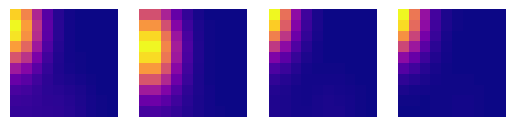

In [27]:
## compute PH and vectorise
import persim,cripser
import importlib

#pim=persim.PersImage(pixels=[10,10], spread=1)
pim=PersImage(pixels=[10,10], spread=1)
pds, pims = [], []
for i in range(len(X)):
    pd = cripser.computePH(X[i])[:,1:3]    # compute PH
    pds.append(np.clip(pd,a_min=-2,a_max=2))  # clip min/max birth/death
    pims.append(pim.transform(pds[i])) # vectorise by persistence image
for i in range(4):   # plot persistence images
    ax = plt.subplot(240+i+1)
    pim.show(pims[i], ax)

In [29]:
# linear regression for the period with Lasso
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

# train-test split
(trainX, testX, trainY, testY) = train_test_split(np.array(pims).reshape(n,-1), b, test_size = 0.3, random_state = 0) # use PH features
#(trainX, testX, trainY, testY) = train_test_split(X, b, test_size = 0.3, random_state = 0)  # see what happens if we use the input data directly

# fit model
clf = linear_model.Lasso(alpha=0.0001,normalize=True,max_iter=10000)
clf.fit(trainX, trainY)

# prediction: the result is reasonably good
trainPred = clf.predict(trainX)
testPred = clf.predict(testX)
print('MSE train : %.3f, test : %.3f' % (mean_squared_error(trainY,trainPred), mean_squared_error(testY,testPred)) )
print('R2 train : %.3f, test : %.3f' % (r2_score(trainY,trainPred), r2_score(testY,testPred)) )


MSE train : 0.046, test : 0.094
R2 train : 0.980, test : 0.965


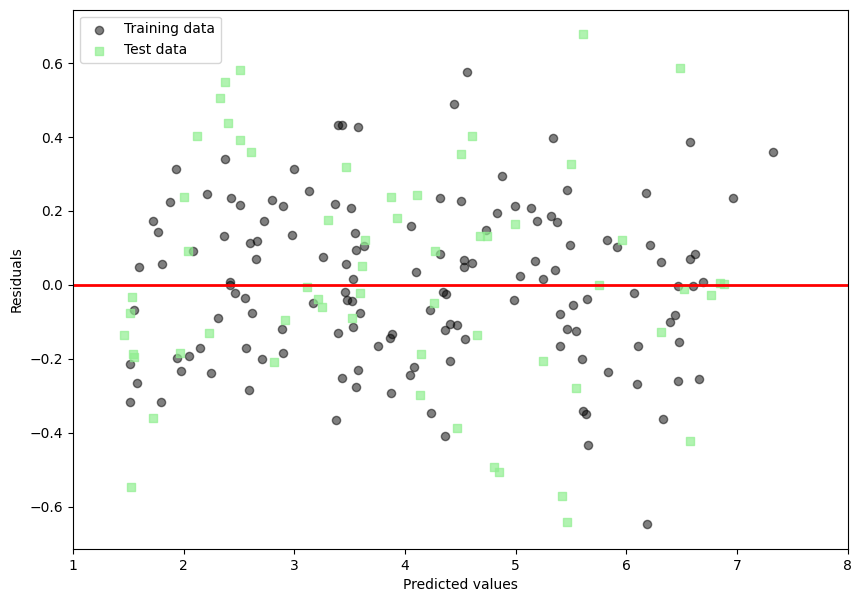

In [30]:
# residual plot
plt.figure(figsize = (10, 7))
plt.scatter(trainPred, trainPred - trainY, c = 'black', marker = 'o', s = 35, alpha = 0.5, label = 'Training data')
plt.scatter(testPred, testPred - testY, c = 'lightgreen', marker = 's', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = 1, xmax = 8, lw = 2, color = 'red')
plt.xlim([1, 8])
plt.show()

## Dimension reduction
Dimension reduction techniques can be used for
- Visualisation
- as a preprocess for regressor/classifier
- outlier detection

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(901, 64)


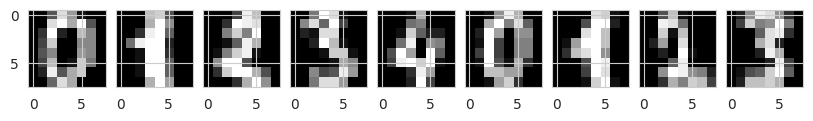

In [31]:
# load demo data: hand written digits
import sklearn
import sklearn.datasets
from scipy import stats
from sklearn import manifold
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import ImageGrid
# seaborn makes matplot drawing charming
import seaborn as sns
sns.set_style("whitegrid")

X,Y = sklearn.datasets.load_digits(n_class=5,return_X_y=True)
print(X.shape)
num_disp=9
fig = plt.figure(figsize=(10, 2))
grid = ImageGrid(fig, 111,nrows_ncols=(1, num_disp),axes_pad=0.1)
for ax,x in zip(grid, X[:num_disp]):
    ax.imshow(x.reshape(8,8),cmap="gray")


### Visualisation

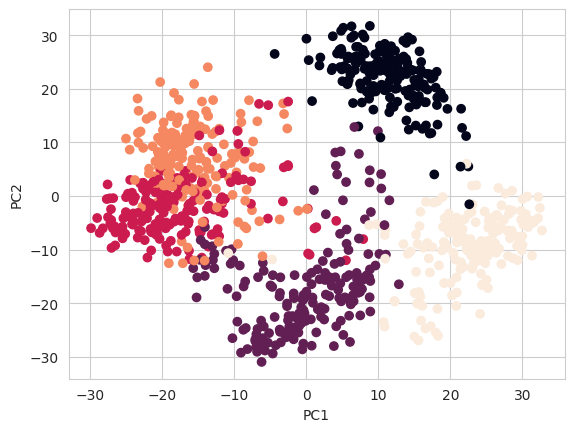

In [40]:
## everyone's favourite PCA: indeed, it is not so bad though there are some overlaps
pca = PCA(n_components=3)
X_pca = pca.fit(X).transform(X)
# plot first and second primary components
plt.scatter(X_pca[:,0],X_pca[:,1],c=Y)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

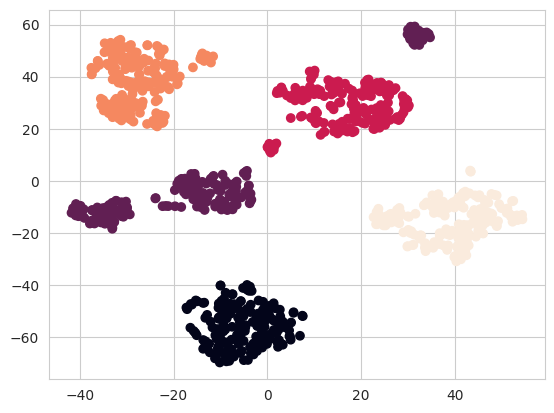

In [33]:
# t-SNE: one of the most popular method. Excellent for preprocess but the meaning of the components are less clear 
X_tsne = manifold.TSNE(n_components=2,perplexity=20).fit_transform(X)
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=Y)


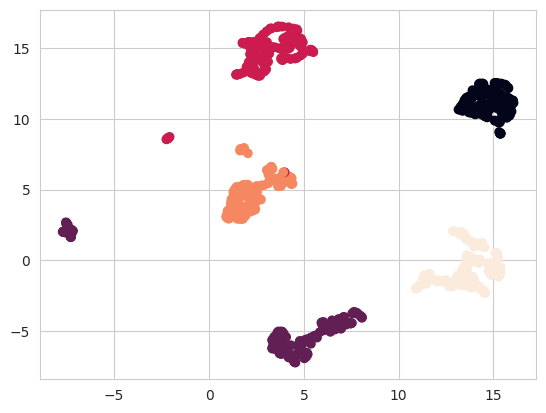

In [34]:
# Universal Manifold Learning (umap): projects vectors while keeping the topology
import umap
X_umap = umap.UMAP(n_components=2, n_neighbors=5, metric='euclidean').fit_transform(X)
plt.scatter(X_umap[:,0],X_umap[:,1],c=Y)

In [35]:
## Mapper: good for revealing rich topology but difficult to tune
# the visualisation does not work with Google Colab. Please use Jupyter-notebook
import kmapper, kmapper.jupyter
from sklearn.preprocessing import StandardScaler
km = kmapper.KeplerMapper()
X_std = StandardScaler().fit_transform(X)   # standardise
f = km.project(X_std,projection="sum") # we have to choose a 1-dim projection
graph = km.map(lens=f, X=X_std, clusterer=sklearn.cluster.DBSCAN(metric="cosine",algorithm='auto', eps=0.3, leaf_size=10))
#nx.draw(kmapper.adapter.to_nx(graph))
km.visualize(graph, color_function=Y, custom_tooltips=Y, path_html="kepler-mapper-output.html")
kmapper.jupyter.display(path_html="kepler-mapper-output.html")

### Classification

In [36]:
## classification with Randomforest
# first, directly with the vector data (image pixel values)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# train-test split
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.3, random_state = 0)

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)

# classification results
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,classification_report
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[52  0  0  0  0]
 [ 0 51  2  5  3]
 [ 0  2 54  3  0]
 [ 0  1  3 47  1]
 [ 1  0  0  0 46]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        52
           1       0.94      0.84      0.89        61
           2       0.92      0.92      0.92        59
           3       0.85      0.90      0.88        52
           4       0.92      0.98      0.95        47

    accuracy                           0.92       271
   macro avg       0.92      0.93      0.92       271
weighted avg       0.92      0.92      0.92       271



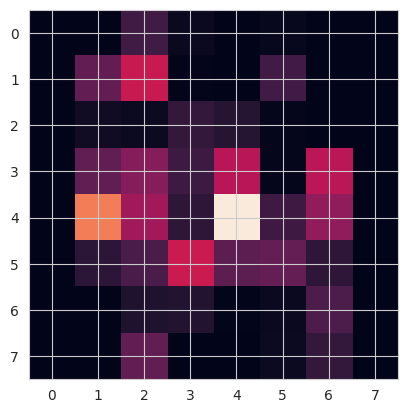

In [37]:
## identify what variables have impact on the decision
# in this case, which pixels are important to distinguish digits
indices = np.argsort(clf.feature_importances_)
#plt.barh(range(len(indices)), clf.feature_importances_[indices])
plt.imshow(clf.feature_importances_.reshape(8,8))

In [38]:
## Now, first dimension reduction (64 -> 5) and classify
# You'll observe the accuracy gets better!
X_umap = umap.UMAP(n_components=5, n_neighbors=5, metric='euclidean').fit_transform(X)
(trainX, testX, trainY, testY) = train_test_split(X_umap, Y, test_size = 0.3, random_state = 0)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(trainX, trainY)
predY = clf.predict(testX)
print("Confusion matrix\n",confusion_matrix(testY,predY))
print(classification_report(testY,predY))

Confusion matrix
 [[52  0  0  0  0]
 [ 0 61  0  0  0]
 [ 0  0 59  0  0]
 [ 0  0  0 52  0]
 [ 0  0  0  0 47]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        59
           3       1.00      1.00      1.00        52
           4       1.00      1.00      1.00        47

    accuracy                           1.00       271
   macro avg       1.00      1.00      1.00       271
weighted avg       1.00      1.00      1.00       271



In [0]:
## lightGBM is one of the most powerful and efficient regressor/classifier based on gradient boosting
#!conda install -c conda-forge lightgbm
